# Infrequent apps

# Document description
In this notebooke we focus on dealing with infrequent apps in the data set

1. Infrequency defined by the number of session in which an app occur
2. Analysing frequency of apps in overall data set
3. Infrequency based on coverage
4. Defining infrequency based on percentage of occurences
5. Tuning infrequency threshold



# Import

In [1]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import ast
pd.options.plotting.backend = "plotly"
import plotly.express as px
from chart_studio import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.subplots as sp
pd.options.display.max_colwidth = None
pd.set_option('display.max_rows', 70)

# Infrequency defined by the number of session in which an app occur

First the data is read into the program

In [13]:
data=pd.read_csv("data_sessions_20s_min_length_1.csv")

Now the number of sessions which each of the apps occure in is calculated.

In [14]:
app_in_n_sessions=data.groupby(['app_code','user_id']).session.nunique().reset_index().groupby("app_code").session.sum()

In [15]:
data=pd.merge(data, app_in_n_sessions.reset_index().rename(columns={'session':'number_of_sessions'}), how='left', on=['app_code'])

In [16]:
data['app_infrequent']=data.number_of_sessions<=(data.shape[0]/100*0.01)

In [17]:
data.shape[0]

181323205

In [18]:
data=data[data.app_infrequent!=True]

In [19]:
data=pd.merge(data,(data.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])

In [20]:
data=data.drop(['session_length'],axis=1)

In [21]:
data=data[data.session_length_updated>1]

Create text file for algorithm input

In [23]:
input_string=data.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [24]:
input_string.to_csv("input_string_without_0_01_apps_no_split.csv",index=False)

In [25]:

input_string=pd.read_csv("input_string_without_0_01_apps_no_split.csv")

In [26]:
print("number of updated sequences:",input_string.shape[0])

number of updated sequences: 52469631


In [27]:
dfAsString = input_string.to_string(header=False, index=False).lstrip()

MemoryError: 

In [ ]:
dfAsString=re.sub(r'\n\s+','\n',dfAsString)

In [ ]:
#update file name
f = open(os.path.join(os.getcwd(), '20sec_sessions_without_0_001_apps_internal_removed.txt'), 'w')
f.write(dfAsString)
f.close()

# Analyzing  frequency of apps in overall data set

In this session we look at the frequency of app for the full data set.

In [2]:
data=pd.read_csv("sorted_coded_session_20s_merged.csv",usecols=['user_id','app_code'])

First we take a look at the distribution of app occurrences.

In [3]:
app_count=data.groupby('app_code').size()

In [4]:
print("min number of times an app occure:",app_count.min())
print("max number of times an app occure:",app_count.max())

min number of times an app occure: 1
max number of times an app occure: 35121339


In [5]:
print("Number of apps which occure only once:",app_count[app_count==1].sum())
print("Number of apps:",app_count.shape[0])

Number of apps which occure only once: 15442
Number of apps: 67088


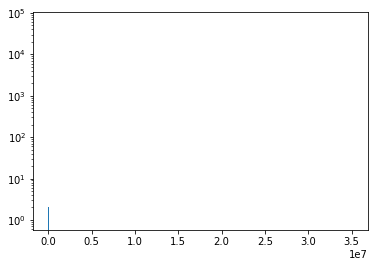

In [6]:
plt.hist(app_count,bins=range(1,app_count.max(),200))
plt.yscale('log')

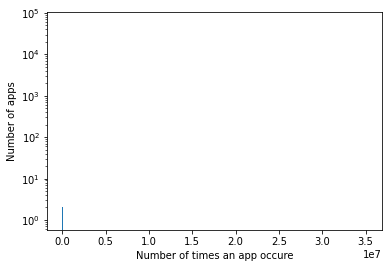

In [7]:
bins=plt.hist(app_count,bins=range(1,app_count.max()+1,200))
plt.yscale('log')
plt.ylabel("Number of apps")
plt.xlabel("Number of times an app occure")
plt.show()

It is clear that the majority of apps are not used that many time.

In [8]:
app_count.quantile(q=.99)

9870.650000000023

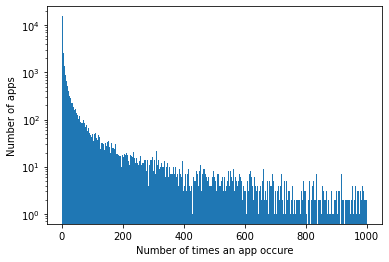

In [9]:
bins=plt.hist(app_count,bins=range(1,1001,1))
plt.yscale('log')
plt.ylabel("Number of apps")
plt.xlabel("Number of times an app occure")
plt.show()

We now take a look at how many apps constitute at least one percent of the observations.

In [10]:
print("Number of apps which constitute at least one percent of the observations",((app_count/data.shape[0]*100)>=1).sum())

Number of apps which constitute at least one percent of the observations 17


In [11]:
print("number of observations:",data.shape[0])

number of observations: 250615269


However ~2.5 mio. obervations is still a high number.

In [12]:
print("Number of apps which constitute at least 0.1 percent of the observations",((app_count/data.shape[0]*100)>=0.1).sum())
print("Number of apps which constitute at least 0.01 percent of the observations",((app_count/data.shape[0]*100)>=0.01).sum())

Number of apps which constitute at least 0.1 percent of the observations 69
Number of apps which constitute at least 0.01 percent of the observations 329


It is overall clear that the majority of observations is made up of only a small number of differnet apps.

# Infrequency based on coverage
In this section we focus on dealing with infrequent apps by keeping only the minimum number of app required to maintaing a certant percantage of all observations.

How many apps are needed in order to maintain 90 procent of the observations?

In [13]:
app_count=app_count.sort_values(ascending=False)

In [14]:
print("number of apps needed to represent 90% of the observations:",app_count.shape[0]-((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=90].shape[0])
print("number of apps needed to represent 95% of the observations:",app_count.shape[0]-((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=95].shape[0])
print("number of apps needed to represent 99% of the observations:",app_count.shape[0]-((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=99].shape[0])
print("number of apps needed to represent 99.5% of the observations:",app_count.shape[0]-((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=99.5].shape[0])
print("number of apps needed to represent 99.9% of the observations:",app_count.shape[0]-((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=99.9].shape[0])

number of apps needed to represent 90% of the observations: 125
number of apps needed to represent 95% of the observations: 483
number of apps needed to represent 99% of the observations: 3780
number of apps needed to represent 99.5% of the observations: 6791
number of apps needed to represent 99.9% of the observations: 18872


In [15]:
print("Number of observations removed by only keeping apps, to maintain 90 % of the observations: ",data.shape[0]-(data.shape[0]/100*90))

Number of observations removed by only keeping apps, to maintain 90 % of the observations:  25061526.900000006


In [16]:
print("Number of observations removed if by only keeping apps, to maintain 95 % of the observations: ",data.shape[0]-(data.shape[0]/100*95))

Number of observations removed if by only keeping apps, to maintain 95 % of the observations:  12530763.450000018


In [17]:
print("Number of observations removed if by only keeping apps, to maintain 99.5 % of the observations: ",data.shape[0]-(data.shape[0]/100*99.5))

Number of observations removed if by only keeping apps, to maintain 99.5 % of the observations:  1253076.3449999988


In [18]:
print("Number of observations removed if by only keeping apps, to maintain 99 % of the observations: ",data.shape[0]-(data.shape[0]/100*99))

Number of observations removed if by only keeping apps, to maintain 99 % of the observations:  2506152.6899999976


We now identify the apps to maintain.

In [19]:
infrequent_apps=app_count[(app_count/data.shape[0]*100).cumsum().shift(1)>=90].index

Now that the infrequent apps have been identified, the infrequent apps can be removed. This is done after the definition of sessions, as the sleeptime should not be affected. 

In [20]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv") #all sessions of length one have already been removed.

In [21]:
data_sessions[data_sessions.app_code.apply(lambda l: l in infrequent_apps)]#test how many apps are removed 

,user_id,package_name,start_time,end_time,app_code,time_spend,sequence_number,sequence_Start_time,sequence_end_time,sleep_time,new_session,session,session_length
10,0,bg.abv.andro.emailapp,3689,3699,2340,10,11,3669,3926,0,False,2,6
26,0,bg.abv.andro.emailapp,33562,33586,2340,24,28,33562,33586,0,False,9,2
28,0,bg.abv.andro.emailapp,44088,44098,2340,10,31,44088,44098,0,False,11,2
31,0,com.adobe.reader,46384,46404,6577,20,35,46384,46404,100,True,14,3
42,0,bg.abv.andro.emailapp,49406,49416,2340,10,49,49406,49416,0,False,19,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181322972,9999,com.americanexpress.android.acctsvcs.uk,28784240,28784260,7464,20,14640,28784240,28784260,101,True,8343,7
181322974,9999,uk.co.ee.myee,28784290,28784330,65645,40,14642,28784290,28784330,10,False,8343,7
181322977,9999,com.americanexpress.android.acctsvcs.uk,28785031,28785081,7464,50,14645,28785031,28785081,10,False,8343,7
181323025,9999,com.instagram.layout,28964716,28964756,27447,40,14705,28964716,28964756,0,False,8372,3


In [22]:
print("Percentage of observations to delete from dataframe:",18455397/data_sessions.shape[0]*100)  

Percentage of observations to delete from dataframe: 10.178177139544825


In [23]:
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)

We now remove the infrequent apps.

In [24]:
data_sessions=data_sessions[data_sessions.infrequent_app!=True]

In [25]:
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 162867808


At last any new sessions of length one are removed.

In [26]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])

In [27]:
data_sessions=data_sessions.drop(['session_length'],axis=1)

In [28]:
data_sessions[data_sessions.session_length_updated==1].shape[0]

5530266

In [29]:
data_sessions=data_sessions[data_sessions.session_length_updated>1]

In [30]:
print("number of observations:",data_sessions.shape[0])

number of observations: 157337542


After the removal of infrequent apps, the text filed used for running the mining algorithms can now be created.

In [32]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [33]:
#update file name
input_string.to_csv("input_string_apps_removed_no_split_to_keep_90.csv",index=False)

In [34]:
input_string=pd.read_csv("input_string_apps_removed_no_split_to_keep_90.csv")

In [35]:
print("number of updated sequences:",input_string.shape[0])

number of updated sequences: 50302216


In [36]:
np.savetxt('20sec_sessions_apps_removed_no_split_to_keep_90.txt', input_string.app_code.values, fmt='%s')

## Runing mining algorithms

In [37]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_no_split_to_keep_90.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20s_sessions_keep_90_min_sup_10.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.1])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20s_sessions_keep_95_min_sup_10.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 240990 ms
 Frequent sequences count : 7
 Max memory (mb) : 7448.7356414794927
minsup 5030222
Intersection count 0 


   pattern       sup
0  [53003]  14312495
1  [45264]   7936052
2  [27441]   5924256
3  [23949]   8722778
4  [19973]   7156797
5  [19968]  19391678
6   [7649]  13684619


In [38]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_no_split_to_keep_90.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_apps_removed_no_split_to_keep_90_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_apps_removed_no_split_to_keep_90_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 529556 ms
 Frequent sequences count : 84
 Max memory (mb) : 12113.26039886474684
minsup 503023
Intersection count 415 


                 pattern      sup
0                [53996]  1057562
1                [49042]   512494
2                [45846]  1559174
3                [45284]   840752
4                [45246]   768551
..                   ...      ...
79  [23949, 7649, 19968]   519576
80  [19968, 23949, 7649]   637146
81  [19968, 7649, 19968]   810573
82   [23949, 7649, 7649]   560004
83   [7649, 23949, 7649]   627769

[84 rows x 2 columns]


In [39]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_no_split_to_keep_90.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_apps_removed_no_split_to_keep_90_min_sup_0_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.001])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_apps_removed_no_split_to_keep_90_min_sup_0_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 2734576 ms
 Frequent sequences count : 1179
 Max memory (mb) : 12424.9104614257811179
minsup 50303
Intersection count 12146 


                                       pattern     sup
0                                      [66375]   81303
1                                      [66136]  131634
2                                      [65957]   97491
3                                      [65471]  125378
4                                      [62624]   97901
...                                        ...     ...
1174  [23949, 23949, 7649, 23949, 7649, 23949]   52815
1175   [7649, 23949, 7649, 23949, 7649, 23949]   57362
1176   [23949, 7649, 23949, 7649, 23949, 7649]   79597
1177   [23949, 7649, 7649, 23949, 7649, 23949]   51078
1178   [23949, 7649, 23949, 7649, 7649, 23949]   50573

[1179 rows x 2 columns]


As we see tah it does complete with a 90% coverage, we increase to 95%

In [40]:
infrequent_apps=app_count[(app_count/data.shape[0]*100).cumsum().shift(1)>=95].index

In [41]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv") #all sessions of length one have already been removed.

data_sessions[data_sessions.app_code.apply(lambda l: l in infrequent_apps)]#test how many apps are removed 

,user_id,package_name,start_time,end_time,app_code,time_spend,sequence_number,sequence_Start_time,sequence_end_time,sleep_time,new_session,session,session_length
10,0,bg.abv.andro.emailapp,3689,3699,2340,10,11,3669,3926,0,False,2,6
26,0,bg.abv.andro.emailapp,33562,33586,2340,24,28,33562,33586,0,False,9,2
28,0,bg.abv.andro.emailapp,44088,44098,2340,10,31,44088,44098,0,False,11,2
42,0,bg.abv.andro.emailapp,49406,49416,2340,10,49,49406,49416,0,False,19,4
53,0,bg.abv.andro.emailapp,87001,87021,2340,20,65,87001,87021,2981,True,29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181322654,9999,com.americanexpress.android.acctsvcs.uk,28097092,28097162,7464,70,14252,28097092,28097162,0,False,8138,8
181322970,9999,com.americanexpress.android.acctsvcs.uk,28784029,28784109,7464,80,14638,28784029,28784109,0,False,8342,4
181322972,9999,com.americanexpress.android.acctsvcs.uk,28784240,28784260,7464,20,14640,28784240,28784260,101,True,8343,7
181322977,9999,com.americanexpress.android.acctsvcs.uk,28785031,28785081,7464,50,14645,28785031,28785081,10,False,8343,7


In [42]:
print("Percentage of observations to delete from dataframe:",9177790/data_sessions.shape[0]*100)

Percentage of observations to delete from dataframe: 5.061563962538606


In [43]:
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)

In [44]:
data_sessions=data_sessions[data_sessions.infrequent_app!=True]

print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 172145415


In [45]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])

data_sessions=data_sessions.drop(['session_length'],axis=1)

data_sessions[data_sessions.session_length_updated==1].shape[0]

data_sessions=data_sessions[data_sessions.session_length_updated>1]

print("number of observations:",data_sessions.shape[0])

number of observations: 169273556


In [46]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

KeyError: 'session'

In [ ]:
np.savetxt('20sec_sessions_apps_removed_no_split_to_keep_95.txt', input_string.values, fmt='%s')

In [ ]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_no_split_to_keep_95.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20s_sessions_keep_95_no_split_min_sup_0_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.001])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20s_sessions_keep_95_no_split_min_sup_0_1.csv")

Again we see if we can go higher

In [47]:
infrequent_apps=app_count[(app_count/data.shape[0]*100).cumsum().shift(1)>=96].index

In [53]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv",usecols=['user_id','app_code','new_session','session','session_length']) #all sessions of length one have already been removed.

data_sessions[data_sessions.app_code.apply(lambda l: l in infrequent_apps)]#test how many apps are removed 

,user_id,app_code,new_session,session,session_length
10,0,2340,False,2,6
26,0,2340,False,9,2
28,0,2340,False,11,2
42,0,2340,False,19,4
53,0,2340,True,29,4
...,...,...,...,...,...
181317923,9999,13078,False,4733,2
181318868,9999,13078,False,5496,3
181319156,9999,38520,False,5752,2
181319574,9999,1312,False,6045,10


In [54]:
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)

In [55]:
data_sessions=data_sessions[data_sessions.infrequent_app!=True]

print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 173989253


In [50]:
data_sessions=data_sessions[data_sessions.infrequent_app!=True]

print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 173989253


In [56]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])

data_sessions=data_sessions.drop(['session_length'],axis=1)

data_sessions[data_sessions.session_length_updated==1].shape[0]

data_sessions=data_sessions[data_sessions.session_length_updated>1]

print("number of observations:",data_sessions.shape[0])

number of observations: 171682160


In [57]:
data_sessions

,user_id,app_code,new_session,session,infrequent_app,session_length_updated
0,0,19968,False,0,False,7
1,0,7649,False,0,False,7
2,0,23916,False,0,False,7
3,0,19968,False,0,False,7
4,0,53003,False,0,False,7
...,...,...,...,...,...,...
173989248,9999,45264,True,8464,False,2
173989249,9999,19968,False,8464,False,2
173989250,9999,23949,True,8465,False,3
173989251,9999,7649,False,8465,False,3


In [59]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [60]:
np.savetxt('20sec_sessions_apps_removed_to_keep_96_no_split.txt', input_string.values, fmt='%s')

In [61]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_to_keep_96_no_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_220sec_sessions_apps_removed_to_keep_96_no_split_min_sup_0_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.001])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_220sec_sessions_apps_removed_to_keep_96_no_split_min_sup_0_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 3470106 ms
 Frequent sequences count : 1088
 Max memory (mb) : 11365.4083633422851088
minsup 53979
Intersection count 10791 


                                         pattern     sup
0                                        [66375]   84243
1                                        [66136]  137062
2                                        [65957]  101594
3                                        [65471]  132174
4                                        [65457]   60236
...                                          ...     ...
1083  [53003, 19968, 53003, 19968, 53003, 19968]   79195
1084    [23949, 7649, 23949, 23949, 7649, 23949]   66174
1085    [23949, 7649, 23949, 7649, 23949, 23949]   56967
1086     [7649, 23949, 7649, 23949, 7649, 23949]   57362
1087     [23949, 7649, 23949, 7649, 23949, 7649]   79597

[1088 rows x 2 columns]


This also completed, so we try to further increase the coverage.

In [62]:
infrequent_apps=app_count[(app_count/data.shape[0]*100).cumsum().shift(1)>=97].index

In [63]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv",usecols=['user_id','app_code','new_session','session_length','session']) #all sessions of length one have already been removed.

data_sessions[data_sessions.app_code.apply(lambda l: l in infrequent_apps)]

,user_id,app_code,new_session,session,session_length
10,0,2340,False,2,6
26,0,2340,False,9,2
28,0,2340,False,11,2
42,0,2340,False,19,4
53,0,2340,True,29,4
...,...,...,...,...,...
181316350,9999,38520,True,3498,2
181316610,9999,1312,False,3715,3
181317050,9999,1312,False,4070,3
181319156,9999,38520,False,5752,2


In [65]:
data_sessions["infrequent_app"]=data_sessions.app_code.isin(infrequent_apps)

In [66]:
data_sessions=data_sessions[data_sessions.infrequent_app!=True]

print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 175820326


In [67]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])

data_sessions=data_sessions.drop(['session_length'],axis=1)

data_sessions[data_sessions.session_length_updated==1].shape[0]

data_sessions=data_sessions[data_sessions.session_length_updated>1]

print("number of observations:",data_sessions.shape[0])

number of observations: 174080633


In [68]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [69]:
np.savetxt('20sec_sessions_apps_removed_to_keep_no_split_97.txt', input_string.values, fmt='%s')

In [70]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_to_keep_no_split_97.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_apps_removed_to_keep_no_split_97min_sup_0_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.001])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_apps_removed_to_keep_no_split_97min_sup_0_1.csv")

CalledProcessError: Command '['java', '-jar', '/home/s164574/motifs_and_competition_in_app_usage/spmf.jar', 'run', 'VMSP', '/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_to_keep_no_split_97.txt', '/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_apps_removed_to_keep_no_split_97min_sup_0_1.txt', '0.001']' returned non-zero exit status 1.

We have failed to increase the coverage, without out experienceing memory errors. Therefor 96% is the coverage. With the 0.1 percent support, this however resulted in a very high number of maximal patterns. To get a better overview, a higher min. sup. is applied.

In [71]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_to_keep_96_no_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_220sec_sessions_apps_removed_to_keep_96_no_split_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_220sec_sessions_apps_removed_to_keep_96_no_split_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 1187627 ms
 Frequent sequences count : 75
 Max memory (mb) : 8129.64617919921975
minsup 539783
Intersection count 379 


                 pattern      sup
0                [53996]  1083959
1                [45846]  1608211
2                [45284]   873447
3                [45246]   792741
4                [36529]   797498
..                   ...      ...
70  [23949, 7649, 23949]  1194735
71  [19968, 23949, 7649]   637146
72  [19968, 7649, 19968]   810573
73   [23949, 7649, 7649]   560004
74   [7649, 23949, 7649]   627769

[75 rows x 2 columns]


## Translating results

In [76]:
data = pd.read_csv('sorted_coded_data.csv',usecols=['app_code','package_name'])
app_dict=dict(zip(data.app_code, data.package_name))

In [138]:
output=pd.read_csv("output_VMSP_220sec_sessions_apps_removed_to_keep_96_no_split_min_sup_0_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20s_sessions_keep_96_no_split_min_sup_0_1_translated.csv",index=False)

In [139]:
output.pattern_length.max()

6

## Analysing the maximal patterns

To help interpret the large results, we start by taking a look at the distribution of app occurences in the patterns.

In [140]:
output=pd.read_csv("output_VMSP_20s_sessions_keep_96_no_split_min_sup_0_1_translated.csv")

In [141]:
output_app_count=pd.DataFrame(output["pattern"].str.replace("[\[\]\'\s]", "").str.split(',', expand=True).values).apply(pd.value_counts).sum(axis=1).sort_values()

<ipython-input-141-f78eb71e969e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  output_app_count=pd.DataFrame(output["pattern"].str.replace("[\[\]\'\s]", "").str.split(',', expand=True).values).apply(pd.value_counts).sum(axis=1).sort_values()


In [142]:
output_app_count.shape[0]

143

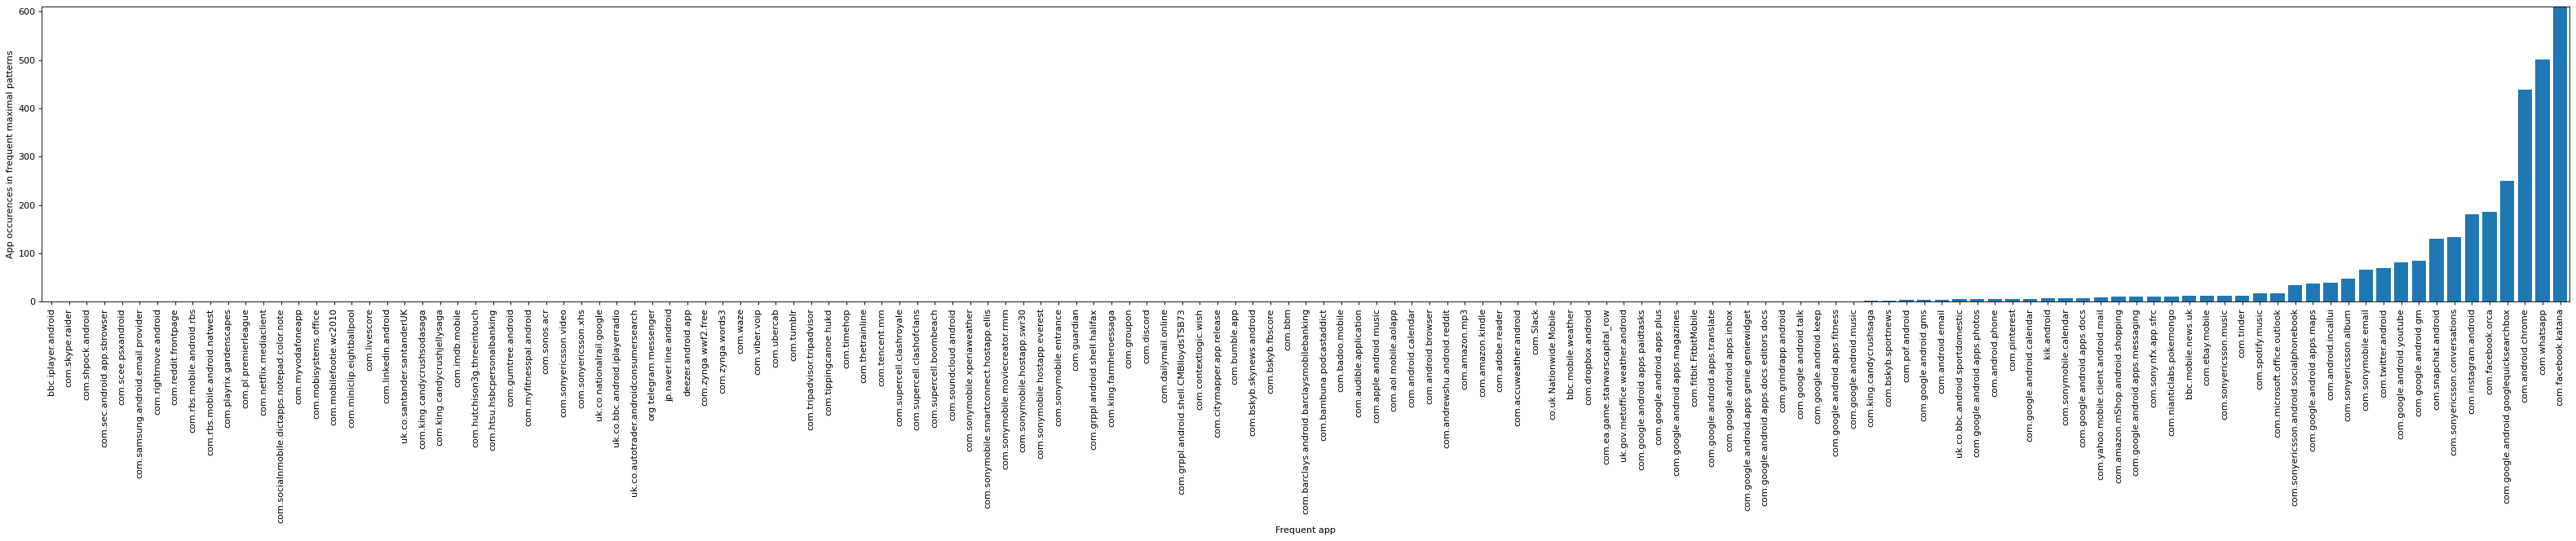

In [143]:
plt.figure(figsize=(50, 6), dpi=80)
bins=plt.bar(output_app_count.index,output_app_count)
plt.ylabel("App occurences in frequent maximal patterns")
plt.xlabel("Frequent app")
plt.xticks(rotation=90) 
plt.margins(0.001)
plt.show()

In [144]:
print("Number of frequent apps occuring once:",output_app_count[output_app_count==1].shape[0])

Number of frequent apps occuring once: 103


We see that the majority only occur once.

In [146]:
output_app_count[output_app_count==1].index

Index(['bbc.iplayer.android', 'com.skype.raider', 'com.shpock.android',
       'com.sec.android.app.sbrowser', 'com.scee.psxandroid',
       'com.samsung.android.email.provider', 'com.rightmove.android',
       'com.reddit.frontpage', 'com.rbs.mobile.android.rbs',
       'com.rbs.mobile.android.natwest',
       ...
       'com.fitbit.FitbitMobile', 'com.google.android.apps.translate',
       'com.google.android.apps.inbox',
       'com.google.android.apps.genie.geniewidget',
       'com.google.android.apps.docs.editors.docs', 'com.grindrapp.android',
       'com.google.android.talk', 'com.google.android.keep',
       'com.google.android.apps.fitness', 'com.google.android.music'],
      dtype='object', length=103)

In [160]:
sum(output.pattern_length==1)

95

In [158]:
patterns_longer_than_1=output[output.pattern_length!=1]
patterns_longer_than_1[patterns_longer_than_1.pattern.str.contains('|'.join(output_app_count[output_app_count==1].index))]

,pattern,sup,pattern_length
494,"['com.sonymobile.xperiaweather', 'com.android.chrome']",77300,2
597,"['com.reddit.frontpage', 'com.android.chrome']",71338,2
684,"['com.viber.voip', 'com.facebook.katana']",67107,2
784,"['com.facebook.katana', 'com.dailymail.online']",63024,2
798,"['com.whatsapp', 'com.sonyericsson.video']",62527,2
903,"['com.fitbit.FitbitMobile', 'com.facebook.katana']",59028,2
918,"['com.facebook.katana', 'com.barclays.android.barclaysmobilebanking']",58423,2
927,"['com.google.android.apps.genie.geniewidget', 'com.android.chrome']",58185,2
1016,"['com.facebook.katana', 'bbc.mobile.weather']",55782,2


The remaining patterns which only occur once, can be see to occur in patterns with some of the most popular apps in the data set, which makes it unclear if the patterns represent a connection between the apps, or if it is simliy just the large number of times these popular apps occur, that also make them more likely to be used with these apps.

In [169]:
output_app_count[output_app_count.isin(output_app_count.nlargest(10))].sort_values(ascending=False)

com.facebook.katana                        610.0
com.whatsapp                               501.0
com.android.chrome                         439.0
com.google.android.googlequicksearchbox    249.0
com.facebook.orca                          185.0
com.instagram.android                      180.0
com.sonyericsson.conversations             133.0
com.snapchat.android                       131.0
com.google.android.gm                       84.0
com.google.android.youtube                  81.0
dtype: float64

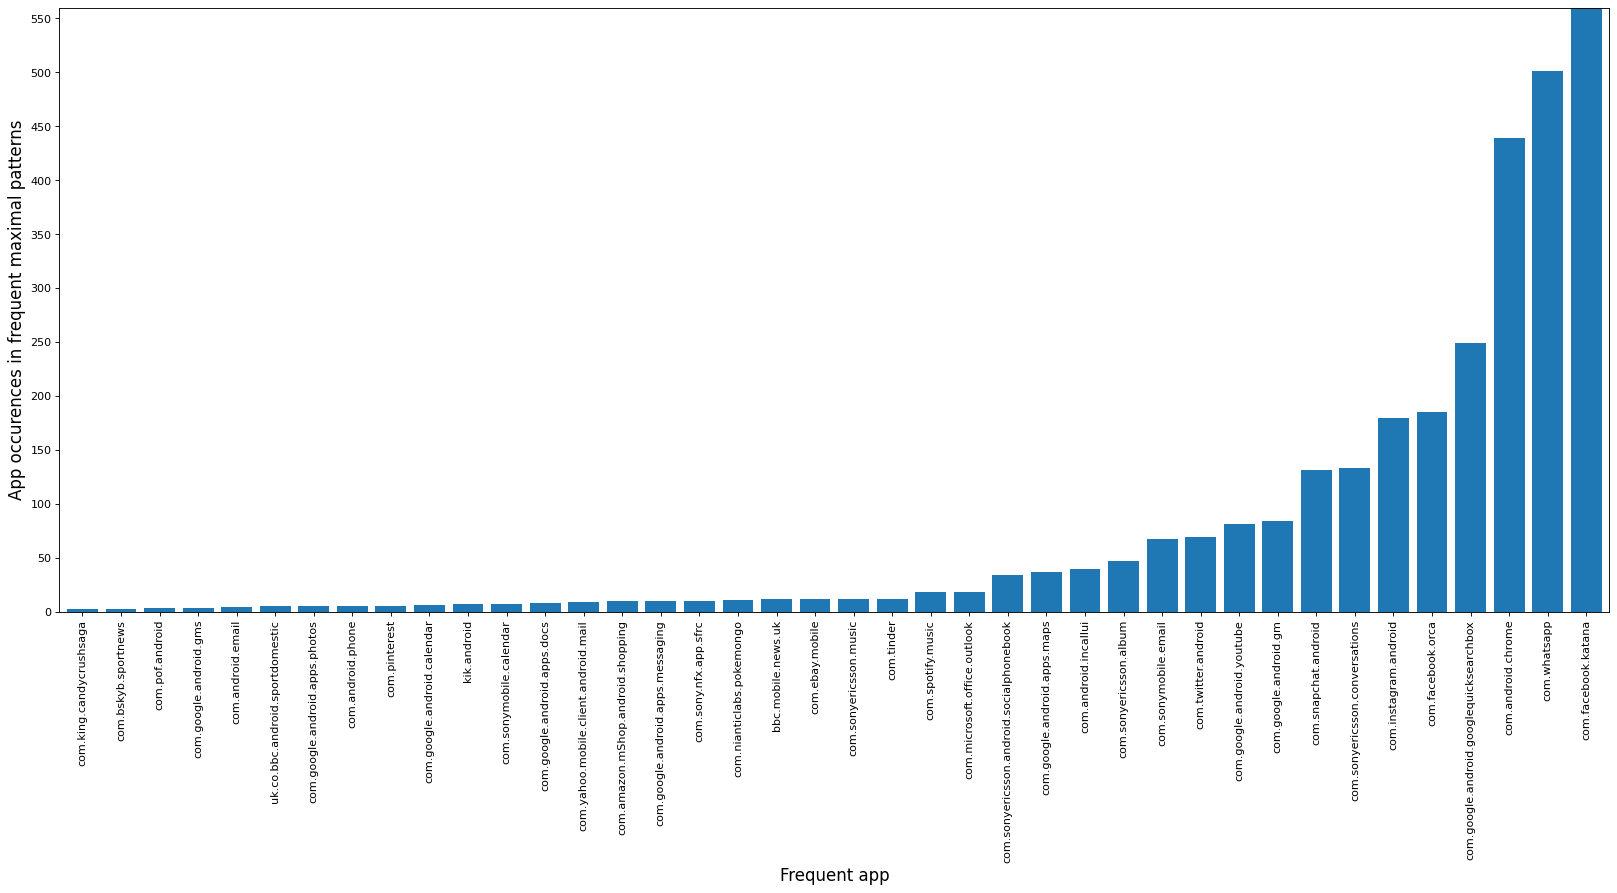

In [172]:
plt.figure(figsize=(25, 10), dpi=80)
bins=plt.bar(output_app_count[output_app_count>1].index,output_app_count[output_app_count>1])
plt.ylabel("App occurences in frequent maximal patterns",fontsize=15)
plt.xlabel("Frequent app",fontsize=15)
plt.xticks(rotation=90,fontsize=10) 
plt.yticks(np.arange(0, 560, 50),fontsize=10)
plt.ylim(0,560)
plt.margins(0.005)
plt.savefig("app_count_in_frequent_patterns_96coverage_no_split.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=1)
plt.show()

# Defining infrequency based on percentage of occurences
In this section we will explore an alternative approach to dealing with infrequent apps. Here the frequency is defined based on how many of the observations belong to each app.

In [127]:
data=pd.read_csv("sorted_coded_session_20s_merged.csv",usecols=['user_id','app_code','package_name','session','new_session'])

In [128]:
app_count=data.groupby('app_code').size()

In [129]:
app_count=app_count.sort_values(ascending=False)

In [130]:
print("Number of apps:",app_count.shape[0])
print("Number of apps which make up at least one percent of the observations:",(app_count/app_count.sum()*100)[app_count/app_count.sum()*100>=1].shape[0])

Number of apps: 67088
Number of apps which make up at least one percent of the observations: 17


In [131]:
infrequent_apps=app_count[app_count/data.shape[0]*100<0.01].index

In [132]:
print("number of infrequent apps for 0.01 thresshold:",len(infrequent_apps))

number of infrequent apps for 0.01 thresshold: 66759


In [12]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv",usecols=['user_id','app_code','session','new_session','session_length']) #all sessions of length one have already been removed.

In [13]:
data_sessions.shape[0]

181323205

In [14]:
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)

In [15]:
data_sessions=data_sessions[data_sessions.infrequent_app!=True]

In [16]:
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 169980345


In [18]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])

In [19]:
data_sessions=data_sessions.drop(['session_length'],axis=1)

In [20]:
data_sessions=data_sessions[data_sessions.session_length_updated>1]

In [23]:
print("number of observations:",data_sessions.shape[0])

number of observations: 166466573


In [24]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [25]:
np.savetxt('20sec_sessions_0_01_removed_without_split.txt', input_string.values, fmt='%s')

In [26]:
print("number of updated sessions:",input_string.shape[0]) # when splitting the sessions to remove infrequent apps: 52,838,635

number of updated sessions: 52642846


In [27]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_01_removed_without_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_01_removed_without_split_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_0_01_removed_without_split_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 570056 ms
 Frequent sequences count : 80
 Max memory (mb) : 14128.63593292236380
minsup 526429
Intersection count 403 


                 pattern      sup
0                [53996]  1074492
1                [45846]  1590487
2                [45284]   860977
3                [45246]   783659
4                [36529]   787773
..                   ...      ...
75  [23949, 7649, 23949]  1194735
76  [19968, 23949, 7649]   637146
77  [19968, 7649, 19968]   810573
78   [7649, 23949, 7649]   627769
79   [23949, 7649, 7649]   560004

[80 rows x 2 columns]


In [28]:
data = pd.read_csv('sorted_coded_data.csv')
app_dict=dict(zip(data.app_code, data.package_name))

In [29]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_01_removed_without_split_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20sec_sessions_0_01_removed_without_split_min_sup_1.csv",index=False)

In [31]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_01_removed_without_split_min_sup_1.csv")

In [33]:
print("number of length one patterns:",output[output.pattern_length==1].shape[0])
print("longest pattern:",output.pattern_length.max())

number of length one patterns: 12
longest pattern: 3


# Tuning infrequency threshold
In this section we continue with the definition of infrequency which is based on the percent of observations an app belong to. Here we tune the infrequency threshold, while keeping the min. sup. sonstat at 1 percent.

In [22]:
data=pd.read_csv("sorted_coded_session_20s_merged.csv")
app_count=data.groupby('app_code').size()
app_count=app_count.sort_values(ascending=False)

In [23]:
infrequent_apps=app_count[app_count/data.shape[0]*100<0.3].index
print("Number of infrequent apps:",len(infrequent_apps))

Number of infrequent apps: 67061


In [24]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv")
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)
data_sessions=data_sessions[data_sessions.infrequent_app!=True]
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 142999696


In [25]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])
data_sessions=data_sessions.drop(['session_length'],axis=1)
data_sessions=data_sessions[data_sessions.session_length_updated>1]
print("number of observations:",data_sessions.shape[0])

number of observations: 132157969


In [26]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
print("number of sessions:",input_string.shape[0])

number of sessions: 43498765


In [27]:
np.savetxt('20sec_sessions_0_3_removed_without_split.txt', input_string.values, fmt='%s')

In [28]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_3_removed_without_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_3_removed_without_split_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_0_3_removed_without_split_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 450179 ms
 Frequent sequences count : 95
 Max memory (mb) : 11160.40138244628995
minsup 434988
Intersection count 518 


                 pattern      sup
0                [53996]  1001079
1                [49042]   486526
2                [45846]  1471780
3                [45284]   779110
4                [45246]   722253
..                   ...      ...
90  [19968, 19968, 7649]   438452
91   [23949, 7649, 7649]   560004
92   [7649, 23949, 7649]   627769
93   [7649, 19968, 7649]   478989
94    [7649, 7649, 7649]   480170

[95 rows x 2 columns]


In [29]:
data = pd.read_csv('sorted_coded_data.csv')
app_dict=dict(zip(data.app_code, data.package_name))

In [30]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_3_removed_without_split_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20sec_sessions_0_3_removed_without_split_min_sup_1_translated.csv",index=False)

In [31]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 11
Max lengths of frequent patterns: 3


In [32]:
infrequent_apps=app_count[app_count/data.shape[0]*100<0.003].index
print("Number of infrequent apps:",len(infrequent_apps))

Number of infrequent apps: 66291


In [33]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv")
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)
data_sessions=data_sessions[data_sessions.infrequent_app!=True]
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 174658676


In [34]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])
data_sessions=data_sessions.drop(['session_length'],axis=1)
data_sessions=data_sessions[data_sessions.session_length_updated>1]
print("number of observations:",data_sessions.shape[0])

number of observations: 172556762


In [35]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
print("number of sessions:",input_string.shape[0])

number of sessions: 54202409


In [36]:
np.savetxt('20sec_sessions_0_003_removed_without_split.txt', input_string.values, fmt='%s')

In [37]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_003_removed_without_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_003_removed_without_split_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_0_003_removed_without_split_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 1259815 ms
 Frequent sequences count : 75
 Max memory (mb) : 8184.32987213134875
minsup 542025
Intersection count 379 


                 pattern      sup
0                [53996]  1085401
1                [45846]  1611363
2                [45284]   875613
3                [45246]   794018
4                [36529]   799027
..                   ...      ...
70  [23949, 7649, 23949]  1194735
71  [19968, 23949, 7649]   637146
72  [19968, 7649, 19968]   810573
73   [7649, 23949, 7649]   627769
74   [23949, 7649, 7649]   560004

[75 rows x 2 columns]


In [38]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_003_removed_without_split_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20sec_sessions_0_003_removed_without_split_min_sup_1_translated.csv",index=False)

In [39]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 11
Max lengths of frequent patterns: 3


In [40]:
infrequent_apps=app_count[app_count/data.shape[0]*100<0.001].index
print("Number of infrequent apps:",len(infrequent_apps))

Number of infrequent apps: 65420


In [41]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv")
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)
data_sessions=data_sessions[data_sessions.infrequent_app!=True]
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 177448830


In [42]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])
data_sessions=data_sessions.drop(['session_length'],axis=1)
data_sessions=data_sessions[data_sessions.session_length_updated>1]
print("number of observations:",data_sessions.shape[0])

number of observations: 176223112


In [43]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
print("number of sessions:",input_string.shape[0])

number of sessions: 55136412


In [44]:
np.savetxt('20sec_sessions_0_001_removed_without_split.txt', input_string.values, fmt='%s')

In [45]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_001_removed_without_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_001_removed_without_split_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_0_001_removed_without_split_min_sup_1.csv")

CalledProcessError: Command '['java', '-jar', '/home/s164574/motifs_and_competition_in_app_usage/spmf.jar', 'run', 'VMSP', '/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_001_removed_without_split.txt', '/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_001_removed_without_split_min_sup_1.txt', '0.01']' returned non-zero exit status 1.

In [ ]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_001_removed_without_split_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20sec_sessions_0_001_removed_without_split_min_sup_1_translated.csv",index=False)

In [ ]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

In [63]:
infrequent_apps=app_count[app_count/data.shape[0]*100<0.05].index
print("Number of infrequent apps:",len(infrequent_apps))

Number of infrequent apps: 66982


In [64]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv")
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)
data_sessions=data_sessions[data_sessions.infrequent_app!=True]
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 161274638


In [65]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])
data_sessions=data_sessions.drop(['session_length'],axis=1)
data_sessions=data_sessions[data_sessions.session_length_updated>1]
print("number of observations:",data_sessions.shape[0])

number of observations: 155275531


In [66]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
print("number of sessions:",input_string.shape[0])

number of sessions: 49750835


In [67]:
np.savetxt('20sec_sessions_0_05_removed_without_split.txt', input_string.values, fmt='%s')

In [68]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_05_removed_without_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_05_removed_without_split_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_0_05_removed_without_split_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 573931 ms
 Frequent sequences count : 85
 Max memory (mb) : 11641.91619110107485
minsup 497509
Intersection count 426 


                 pattern      sup
0                [53996]  1053192
1                [49042]   511634
2                [45846]  1551628
3                [45284]   835487
4                [45246]   764338
..                   ...      ...
80  [23949, 7649, 19968]   519576
81  [19968, 23949, 7649]   637146
82  [19968, 7649, 19968]   810573
83   [23949, 7649, 7649]   560004
84   [7649, 23949, 7649]   627769

[85 rows x 2 columns]


In [69]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_05_removed_without_split_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20sec_sessions_0_05_removed_without_split_min_sup_1_translated.csv",index=False)

In [70]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 14
Max lengths of frequent patterns: 3


In [4]:
infrequent_apps=app_count[app_count/data.shape[0]*100<0.08].index
print("Number of infrequent apps:",len(infrequent_apps))

Number of infrequent apps: 67007


In [5]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv")
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)
data_sessions=data_sessions[data_sessions.infrequent_app!=True]
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 158320770


In [6]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])
data_sessions=data_sessions.drop(['session_length'],axis=1)
data_sessions=data_sessions[data_sessions.session_length_updated>1]
print("number of observations:",data_sessions.shape[0])

number of observations: 151471188


In [7]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
print("number of sessions:",input_string.shape[0])

number of sessions: 48748390


In [8]:
np.savetxt('20sec_sessions_0_08_removed_without_split.txt', input_string.values, fmt='%s')

In [9]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_08_removed_without_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_08_removed_without_split_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_0_08_removed_without_split_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 507859 ms
 Frequent sequences count : 87
 Max memory (mb) : 11049.10589599609487
minsup 487484
Intersection count 432 


                 pattern      sup
0                [53996]  1046328
1                [49042]   508249
2                [45846]  1538975
3                [45284]   826395
4                [45246]   758313
..                   ...      ...
82  [23949, 7649, 19968]   519576
83  [19968, 23949, 7649]   637146
84  [19968, 7649, 19968]   810573
85   [23949, 7649, 7649]   560004
86   [7649, 23949, 7649]   627769

[87 rows x 2 columns]


In [12]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_08_removed_without_split_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20sec_sessions_0_08_removed_without_split_min_sup_1_translated.csv",index=False)

In [13]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 14
Max lengths of frequent patterns: 3


In [14]:
infrequent_apps=app_count[app_count/data.shape[0]*100<0.1].index
print("Number of infrequent apps:",len(infrequent_apps))

Number of infrequent apps: 67021


In [15]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv")
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)
data_sessions=data_sessions[data_sessions.infrequent_app!=True]
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 155914969


In [16]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])
data_sessions=data_sessions.drop(['session_length'],axis=1)
data_sessions=data_sessions[data_sessions.session_length_updated>1]
print("number of observations:",data_sessions.shape[0])

number of observations: 148362368


In [17]:
input_string=data_sessions.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
print("number of sessions:",input_string.shape[0])

number of sessions: 47876888


In [18]:
np.savetxt('20sec_sessions_0_1_removed_without_split.txt', input_string.values, fmt='%s')

In [19]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_1_removed_without_split.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_1_removed_without_split_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_0_1_removed_without_split_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 493339 ms
 Frequent sequences count : 89
 Max memory (mb) : 11255.0821838378989
minsup 478769
Intersection count 434 


                 pattern      sup
0                [53996]  1039000
1                [49042]   506467
2                [45846]  1526231
3                [45284]   817949
4                [45246]   751799
..                   ...      ...
84  [19968, 7649, 19968]   810573
85   [23949, 7649, 7649]   560004
86   [7649, 23949, 7649]   627769
87   [7649, 19968, 7649]   478989
88    [7649, 7649, 7649]   480170

[89 rows x 2 columns]


In [20]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_1_removed_without_split_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20sec_sessions_0_1_removed_without_split_min_sup_1_translated.csv",index=False)

In [21]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 14
Max lengths of frequent patterns: 3


The results are here visualised.

In [2]:
tunning_results=pd.read_csv("Tunninf Infrequency threshold.csv")

In [3]:
tunning_results=tunning_results[:16]

In [4]:
tunning_results=tunning_results[1:]

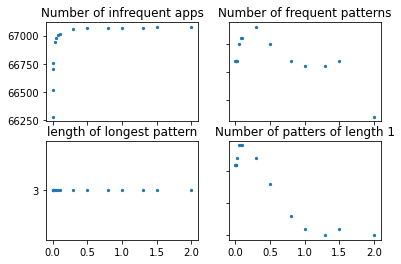

In [5]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(tunning_results['threshold(%)'],tunning_results['num of infrequency apps'],s=5)
axs[0, 0].set_title('Number of infrequent apps')
axs[0, 1].scatter(tunning_results['threshold(%)'],tunning_results['num of frequent patterns founded'],s=5)
axs[0, 1].set_title('Number of frequent patterns')
axs[1, 0].scatter(tunning_results['threshold(%)'],tunning_results['max length of founded pattern'],s=5)
axs[1, 0].set_title('length of longest pattern')
axs[1, 1].scatter(tunning_results['threshold(%)'],tunning_results['num of length 1 founded pattern '],s=5)
axs[1, 1].set_title('Number of patters of length 1')

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
#plt.scatter(tunning_results['threshold(%)'],tunning_results['num of infrequency apps'])

In [12]:
fig1 =px.scatter(tunning_results,x='threshold(%)', y='num of infrequency apps',title = 'Number of infrequent apps')
fig2 =px.scatter(tunning_results,x='threshold(%)', y='num of frequent patterns founded',title = 'Number of frequent patterns')
fig3 =px.scatter(tunning_results,x='threshold(%)', y='max length of founded pattern',title = 'length of longest pattern')
fig4 = px.scatter(tunning_results,x='threshold(%)', y='num of length 1 founded pattern ',title='Number of patters of length 1')

In [13]:
fig2

In [14]:
fig1

In [9]:
fig3

In [10]:
fig4

In [11]:
figure1 = px.scatter(tunning_results,x='threshold(%)', y='num of infrequency apps')
figure2 = px.scatter(tunning_results,x='threshold(%)', y='num of frequent patterns founded')
figure3 = px.scatter(tunning_results,x='threshold(%)', y='max length of founded pattern')
figure4 = px.scatter(tunning_results,x='threshold(%)', y='num of length 1 founded pattern ')


figure1_traces = []
figure2_traces = []
figure3_traces = []
figure4_traces = []
for trace in range(len(figure1["data"])):
    figure1_traces.append(figure1["data"][trace])
for trace in range(len(figure2["data"])):
    figure2_traces.append(figure2["data"][trace])
for trace in range(len(figure3["data"])):
    figure3_traces.append(figure3["data"][trace])
for trace in range(len(figure4["data"])):
    figure4_traces.append(figure4["data"][trace])    
#Create a 1x2 subplot
this_figure = sp.make_subplots(rows=2, cols=2) 

# Get the Express fig broken down as traces and add the traces to the proper plot within in the subplot
for traces in figure1_traces:
    this_figure.append_trace(traces, row=1, col=1)
for traces in figure2_traces:
    this_figure.append_trace(traces, row=1, col=2)
for traces in figure3_traces:
    this_figure.append_trace(traces, row=2, col=1)
for traces in figure4_traces:
    this_figure.append_trace(traces, row=2, col=2)

#the subplot as shown in the above ima

In [37]:
this_figure

Based on the tuning result we continue with continue with a 0.01 percent threshold, to ensure that enough diversity is left in the data set after the infrequent apps have been removed.